Importing The Dependencies

In [203]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
tf.__version__
tf.random.set_seed(3)

In [2]:
dataDaily = pd.read_csv('daily.csv')
dataDaily.head()
dataWeekly = pd.read_csv('weekly.csv')
dataMonthly = pd.read_csv('monthly.csv')
dataMonthly['Day'] = dataMonthly['Day'].astype('datetime64[ns]')
dataWeekly['Day'] = dataWeekly['Day'].astype('datetime64[ns]')
dataDaily[5000:5700].tail()

,Day,Price
5695,20190826,2.23
5696,20190827,2.24
5697,20190828,2.24
5698,20190829,2.36
5699,20190830,2.33


In [3]:
df = dataMonthly['Price']
print(len(dataDaily))

6341


EDA:

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

dc = seasonal_decompose(df, model='multiplicative')
trend = dc.trend
seasonality = dc.seasonal
residual = dc.resid

plt.figure(figsize=(10, 6))
plt.grid(True)
plt.subplot(411)
plt.plot(df, label='Actual Data')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonality, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='best')

Prepping the datasets

In [79]:
s1 = MinMaxScaler(feature_range=(0, 1))

def dailySets(df, size):
  for i in range(len(df)-size):
    temp = [[item[0]] for item in df[i:i+size]]
    xData.append(temp)
    yData.append([df[i+size][0]])

def monthlySets(lookback, pred):
    dataTrain = dataDaily['Price'].to_numpy()
    xData = []
    yData = []

    for i in range(lookback, len(dataTrain)-lookback):
        temp = []
        for item in dataTrain[i-lookback:i]:
            temp.append([item])
        xData.append(temp)
        yData.append(dataTrain[i:i+pred])

    xData = tf.convert_to_tensor(xData, dtype=tf.float32)
    yData = tf.convert_to_tensor(yData, dtype=tf.float32)
    xData = s1.fit_transform(tf.reshape(xData, (-1, 1)))
    yData = s1.fit_transform(tf.reshape(yData, (-1, 1)))

    xData = tf.reshape(xData, (-1, lookback, 1))
    yData = tf.reshape(yData, (-1, pred))
    return (xData, yData)


-> LSTM Model:

Multi step:

In [224]:
model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.LSTM(64, input_shape = (180,1), return_sequences = True))
model1.add(tf.keras.layers.Flatten())
model1.add(tf.keras.layers.Dense(30))
model1.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['mse', 'mae', 'mape'])
model1.summary()

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_53 (LSTM)               (None, 180, 64)           16896     
_________________________________________________________________
flatten_49 (Flatten)         (None, 11520)             0         
_________________________________________________________________
dense_55 (Dense)             (None, 30)                345630    
Total params: 362,526
Trainable params: 362,526
Non-trainable params: 0
_________________________________________________________________


In [226]:
xData, yData = monthlySets(180, 30)
xTrain = xData[:5000]
yTrain = yData[:5000]

xTest = xData[5000:]
yTest = yData[5000:]

print(xTest.shape, yTest.shape)

model1.fit(xTrain, yTrain, epochs = 5)
model1.save('monthlyModelLSTM.h5')

(981, 180, 1) (981, 30)
Epoch 1/5
157/157 [==============================] - 20s 128ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0271 - mape: 14.0492
Epoch 2/5
157/157 [==============================] - 20s 126ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0266 - mape: 13.8087
Epoch 3/5
157/157 [==============================] - 20s 127ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0258 - mape: 13.3491
Epoch 4/5
157/157 [==============================] - 20s 129ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0255 - mape: 13.2763
Epoch 5/5
157/157 [==============================] - 20s 128ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0252 - mape: 13.0753


Single step:

In [227]:
model4 = tf.keras.Sequential()
model4.add(tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(100, 1)))
model4.add(tf.keras.layers.Flatten())
model4.add(tf.keras.layers.Dense(1))
model4.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.Adam(), metrics = ['mse', 'mae', 'mape'])
# model4.summary()

In [228]:
df = dataDaily['Price'][:6000]                 
print("Total Size:", len(df))
scaler = MinMaxScaler(feature_range=(0, 1))
dfPrice = scaler.fit_transform(np.array(df).reshape(-1, 1))
SIZE = 100

xData = []
yData = []

dailySets(dfPrice, SIZE)
xTrain = np.array(xData[:5500])
yTrain = np.array(yData[:5500])
xTest = np.array(xData[5500:])
yTest = np.array(yData[5500:])

model4.fit(xTrain, yTrain, epochs=5)
model4.save('dailyModelLSTM.h5')

Total Size: 6000
Epoch 1/5
172/172 [==============================] - 15s 65ms/step - loss: 0.0029 - mse: 0.0029 - mae: 0.0330 - mape: 13.7561
Epoch 2/5
172/172 [==============================] - 10s 61ms/step - loss: 9.0207e-04 - mse: 9.0207e-04 - mae: 0.0182 - mape: 7.49601s - los
Epoch 3/5
172/172 [==============================] - 10s 59ms/step - loss: 6.5860e-04 - mse: 6.5860e-04 - mae: 0.0151 - mape: 6.2646
Epoch 4/5
172/172 [==============================] - 10s 59ms/step - loss: 5.8844e-04 - mse: 5.8844e-04 - mae: 0.0144 - mape: 6.0283
Epoch 5/5
172/172 [==============================] - 10s 60ms/step - loss: 5.1805e-04 - mse: 5.1805e-04 - mae: 0.0131 - mape: 5.4271


-> CNN Model:

Multi Step:

In [229]:
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Conv1D(64, kernel_size=(4), input_shape=(180, 1)))
model2.add(tf.keras.layers.MaxPool1D(pool_size=3, strides=(1), padding='valid'))
model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.Dense(30))
model2.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['mse', 'mae', 'mape'])
model2.summary()

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_35 (Conv1D)           (None, 177, 64)           320       
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 175, 64)           0         
_________________________________________________________________
flatten_51 (Flatten)         (None, 11200)             0         
_________________________________________________________________
dense_57 (Dense)             (None, 30)                336030    
Total params: 336,350
Trainable params: 336,350
Non-trainable params: 0
_________________________________________________________________


In [254]:
xData, yData = monthlySets(180, 30)
xTrain = xData[:5000]
yTrain = yData[:5000]

xTest = xData[5000:]
yTest = yData[5000:]

print(xTest.shape, yTest.shape)


model2.fit(xTrain, yTrain, epochs = 5)
model2.save('monthlyModelCNN.h5')

(981, 180, 1) (981, 30)


Single step:

In [231]:
model5 = tf.keras.Sequential()
model5.add(tf.keras.layers.Conv1D(64, kernel_size=(4), input_shape=(100, 1)))
model5.add(tf.keras.layers.MaxPool1D(pool_size=3, strides=(1), padding='valid'))
model5.add(tf.keras.layers.Flatten())
model5.add(tf.keras.layers.Dense(1))
model5.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.Adam(), metrics = ['mse', 'mae', 'mape'])
model5.summary()

Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 97, 64)            320       
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 95, 64)            0         
_________________________________________________________________
flatten_52 (Flatten)         (None, 6080)              0         
_________________________________________________________________
dense_58 (Dense)             (None, 1)                 6081      
Total params: 6,401
Trainable params: 6,401
Non-trainable params: 0
_________________________________________________________________


In [232]:
df = dataDaily['Price'][:6000]                 
print("Total Size:", len(df))
scaler = MinMaxScaler(feature_range=(0, 1))
dfPrice = scaler.fit_transform(np.array(df).reshape(-1, 1))
SIZE = 100

xData = []
yData = []

dailySets(dfPrice, SIZE)
xTrain = np.array(xData[:5500])
yTrain = np.array(yData[:5500])
xTest = np.array(xData[5500:])
yTest = np.array(yData[5500:])

model5.fit(xTrain, yTrain, epochs=5)
model5.save('dailyModelCNN.h5')

Total Size: 6000
Epoch 1/5
172/172 [==============================] - 2s 6ms/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0286 - mape: 11.8131
Epoch 2/5
172/172 [==============================] - 1s 5ms/step - loss: 8.0386e-04 - mse: 8.0386e-04 - mae: 0.0171 - mape: 7.0844: 0s - loss: 8.0589e-04 - mse: 8.0589e-04 - mae: 0.0172 - mape: 
Epoch 3/5
172/172 [==============================] - 1s 5ms/step - loss: 6.0681e-04 - mse: 6.0681e-04 - mae: 0.0146 - mape: 6.0546
Epoch 4/5
172/172 [==============================] - 1s 5ms/step - loss: 5.5734e-04 - mse: 5.5734e-04 - mae: 0.0144 - mape: 6.0470
Epoch 5/5
172/172 [==============================] - 1s 5ms/step - loss: 4.4929e-04 - mse: 4.4929e-04 - mae: 0.0122 - mape: 5.1460


-> CNN-LSTM Hybrid Model

Multi Step

In [268]:
model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.Conv1D(32, kernel_size=(3), input_shape=(180, 1)))
model3.add(tf.keras.layers.MaxPool1D(pool_size=3, strides=(1), padding='valid'))
model3.add(tf.keras.layers.LSTM(64, return_sequences=True))
model3.add(tf.keras.layers.Flatten())
model3.add(tf.keras.layers.Dense(30))
model3.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.Adam(), metrics=['mse', 'mae', 'mape'])
model3.summary()

Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 178, 32)           128       
_________________________________________________________________
max_pooling1d_30 (MaxPooling (None, 176, 32)           0         
_________________________________________________________________
lstm_63 (LSTM)               (None, 176, 64)           24832     
_________________________________________________________________
flatten_61 (Flatten)         (None, 11264)             0         
_________________________________________________________________
dense_67 (Dense)             (None, 30)                337950    
Total params: 362,910
Trainable params: 362,910
Non-trainable params: 0
_________________________________________________________________


In [295]:
xData, yData = monthlySets(180, 30)
xTrain = xData[:5000]
yTrain = yData[:5000]

xTest = xData[5000:]
yTest = yData[5000:]

print(xTest.shape, yTest.shape)


model3.fit(xTrain, yTrain, epochs = 5, shuffle=True)
model3.save('monthlyModelCNN-LSTM.h5')

(981, 180, 1) (981, 30)


Single Step

In [250]:
model6 = tf.keras.Sequential()
model6.add(tf.keras.layers.Conv1D(32, kernel_size=(2), input_shape=(100, 1)))
model6.add(tf.keras.layers.LSTM(32, return_sequences=True))
model6.add(tf.keras.layers.Flatten())
model6.add(tf.keras.layers.Dense(1))
model6.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.Adam(), metrics=['mse', 'mae', 'mape'])
# model6.summary()

In [303]:
df = dataDaily['Price'][:6000]                 
print("Total Size:", len(df))
scaler = MinMaxScaler(feature_range=(0, 1))
dfPrice = scaler.fit_transform(np.array(df).reshape(-1, 1))
SIZE = 100

xData = []
yData = []

dailySets(dfPrice, SIZE)
xTrain = np.array(xData[:5500])
yTrain = np.array(yData[:5500])
xTest = np.array(xData[5500:])
yTest = np.array(yData[5500:])

model6.fit(xTrain, yTrain, epochs=5)
model6.save('dailyModelCNNLSTM.h5')

Total Size: 6000


In [270]:
lstm = tf.keras.models.load_model('monthlyModelLSTM.h5')
cnn = tf.keras.models.load_model('monthlyModelCNN.h5')
cnnlstm = tf.keras.models.load_model('monthlyModelCNN-LSTM.h5')

# lstmSing = tf.keras.models.load_model('dailyModelLSTM.h5')
# cnnSing = tf.keras.models.load_model('dailyModelCNN.h5')
# cnnlstmSing = tf.keras.models.load_model('dailyModelCNNLSTM.h5')

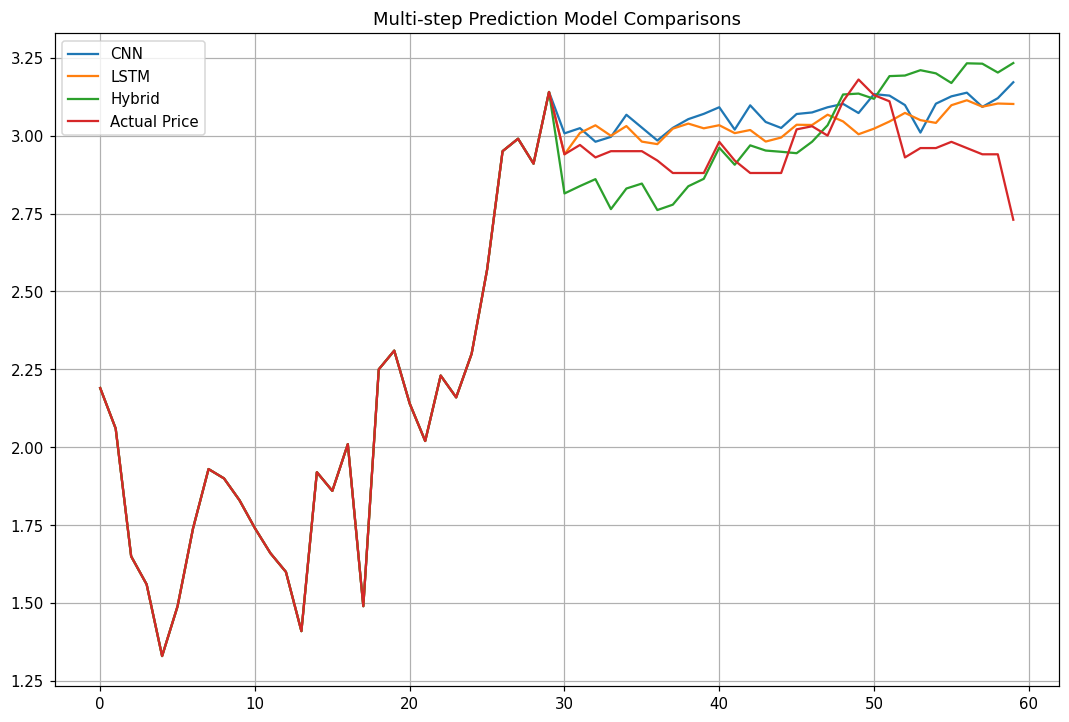

In [271]:
from sklearn.metrics import mean_absolute_percentage_error
# plt.style.use('dark_background')

lstmPred = dataDaily['Price'].to_list()[5970:6000]
cnnPred = dataDaily['Price'].to_list()[5970:6000]
cnnlstmPred = dataDaily['Price'].to_list()[5970:6000]
truth = dataDaily['Price'].to_list()[5970:6000]

index = 10
lstmPred.extend(s1.inverse_transform(lstm.predict(np.expand_dims(xTest[index], axis=0))).flatten())
cnnPred.extend(s1.inverse_transform(cnn.predict(np.expand_dims(xTest[index], axis=0))).flatten())
cnnlstmPred.extend(s1.inverse_transform(cnnlstm.predict(np.expand_dims(xTest[index], axis=0))).flatten())
truth.extend(s1.inverse_transform(tf.reshape(yTest[index], (-1, 1))))
df = pd.DataFrame(data={'CNN': cnnPred, 'LSTM': lstmPred, 'CNN-LSTM': cnnlstmPred, 'Actual': truth})
plt.figure(figsize=(12, 8), dpi=108)
plt.grid(True)
plt.title('Multi-step Prediction Model Comparisons')
plt.plot(df, label=['CNN', 'LSTM', 'Hybrid', 'Actual Price'])
plt.legend()
plt.show()

# mapeObject = tf.keras.losses.MeanAbsolutePercentageError()
# mseObject = tf.keras.losses.MeanSquaredError()
# maeObject = tf.keras.losses.MeanAbsoluteError()
# mape = mapeObject(df['truth'], df['res']).numpy()
# mse = mseObject(df['truth'], df['res']).numpy()
# mae = maeObject(df['truth'], df['res']).numpy()

In [297]:
end = 700

l = lstm.evaluate(xTest[:end], yTest[:end])
c = cnn.evaluate(xTest[:end], yTest[:end])
cl = cnnlstm.evaluate(xTest[:end], yTest[:end])

22/22 [==============================] - 2s 67ms/step - loss: 3.7803e-04 - mse: 3.7803e-04 - mae: 0.0128 - mape: 10.9216


In [289]:
print(l, c, cl, sep = "\n")

[0.0003568771353457123, 0.0003568771353457123, 0.010468926280736923, 7.711786270141602]
[0.00038141122786328197, 0.00038141122786328197, 0.011915425769984722, 9.287092208862305]
[0.00031482407939620316, 0.00031482407939620316, 0.00955883227288723, 7.152036190032959]


Predicting 1 day into the Future:

In [13]:
def dailySets(df, size):
  for i in range(len(df)-size):
    temp = [[item[0]] for item in df[i:i+size]]
    xData.append(temp)
    yData.append([df[i+size][0]])

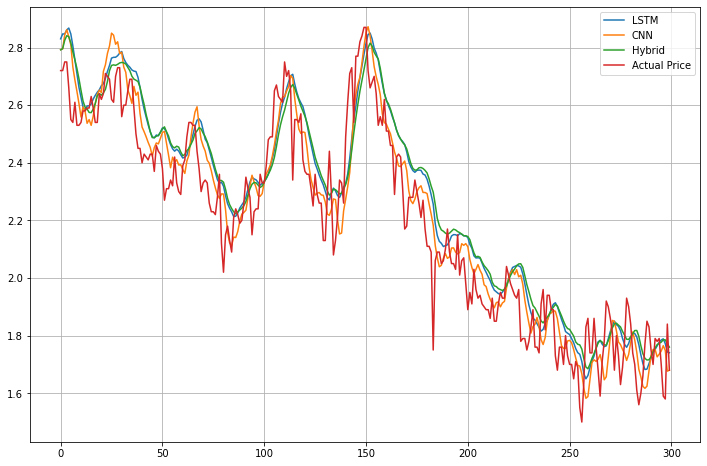

0.0511541981458128


In [309]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


dlstm = tf.keras.models.load_model('dailyModelLSTM.h5')
dcnn = tf.keras.models.load_model('dailyModelCNN.h5')
dcnnlstm = tf.keras.models.load_model('dailyModelCNNLSTM.h5')

analysis1 = scaler.inverse_transform(dlstm.predict(xTest)).flatten()
analysis2 = scaler.inverse_transform(dcnn.predict(xTest)).flatten()
analysis3 = scaler.inverse_transform(dcnnlstm.predict(xTest)).flatten()
truth = scaler.inverse_transform(yTest).flatten()

dfAnalysis = pd.DataFrame(data={'LSTM': analysis1[:300], 'CNN': analysis2[:300], 'CNNLSTM': analysis3[:300], 'Actual Value': truth[:300],})
plt.figure(figsize=(12, 8))
plt.grid(True)
plt.plot(dfAnalysis, label=['LSTM', 'CNN', 'Hybrid', 'Actual Price'])
plt.legend()
plt.show()

print(mean_absolute_percentage_error(truth[:300], analysis1[:300]))

In [305]:
ends = 300

lS = dlstm.evaluate(xTest[:ends], yTest[:ends])
cS = dcnn.evaluate(xTest[:ends], yTest[:ends])
clS = dcnnlstm.evaluate(xTest[:ends], yTest[:ends])

print(lS, cS, clS, sep='\n')

10/10 [==============================] - 1s 13ms/step - loss: 5.5737e-05 - mse: 5.5737e-05 - mae: 0.0062 - mape: 5.3852
[5.1407052524155006e-05, 5.1407052524155006e-05, 0.005926220677793026, 5.115419864654541]
[3.789634502027184e-05, 3.789634502027184e-05, 0.004840700421482325, 4.173659801483154]
[5.573703674599528e-05, 5.573703674599528e-05, 0.006208572071045637, 5.385193347930908]


In [28]:
def getNextDayPred():
    lastData = dataDaily['Price'].to_numpy()[-100:]
    lastData = scaler.fit_transform(lastData.reshape(100, 1))
    day = dt.datetime.strptime(str(dataDaily['Day'].tolist()[-1]), '%Y%m%d').date()+dt.timedelta(days=1)
    return [day, scaler.inverse_transform(model4.predict(np.expand_dims(lastData, axis=0)))[0][0]]

print(getNextDayPred())

[datetime.date(2022, 3, 2), 4.353938]
